## Bound Constraint Optimization

In [1]:
import math
import os
import logging
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('..')


from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.data.plan import FidObjective
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.io.serializedObjectIO import saveRTPlan, loadRTPlan
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D, resampleImage3D
from opentps.core.processing.planOptimization.planOptimization import BoundConstraintsOptimizer, IMPTPlanOptimizer
logger = logging.getLogger(__name__)

24/07/2023 10:38:56 AM - root - INFO - Loading logging configuration: C:\Users\romai\OneDrive - UCL\Job MIRO\OpenTPS\opentps\opentps_core\opentps\core\config\logger\logging_config.json
24/07/2023 10:38:56 AM - opentps.core._loggingConfig - INFO - Log level set: INFO
24/07/2023 10:38:57 AM - opentps.core.processing.imageProcessing.cupyImageProcessing - WARNING - Cannot import Cupy module
24/07/2023 10:38:58 AM - opentps.core.processing.registration.registrationMorphons - WARNING - cupy not found.
24/07/2023 10:38:58 AM - opentps.core.processing.C_libraries.libInterp3_wrapper - WARNING - cupy not found.
24/07/2023 10:38:58 AM - opentps.core.processing.planOptimization.solvers.lp - WARNING - Ignore the following warning if not using Gurobi linear optimizer. Gurobi not required for most features provided in OpenTPS
24/07/2023 10:38:58 AM - opentps.core.processing.planOptimization.solvers.lp - WARNING - No module Gurobi found
!Licence required!
Get free Academic license on https://www.gurob

### Generic example: Box of water with squared targets

In [2]:
output_path = os.getcwd()
logger.info('Files will be stored in {}'.format(output_path))

ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

patient = Patient()
patient.name = 'Patient'

ctSize = 150

ct = CTImage()
ct.name = 'CT'
ct.patient = patient


huAir = -1024.
huWater = ctCalibration.convertRSP2HU(1.)
data = huAir * np.ones((ctSize, ctSize, ctSize))
data[:, 50:, :] = huWater
ct.imageArray = data

roi = ROIMask()
roi.patient = patient
roi.name = 'TV'
roi.color = (255, 0, 0) # red
data = np.zeros((ctSize, ctSize, ctSize)).astype(bool)
data[100:120, 100:120, 100:120] = True
roi.imageArray = data

24/07/2023 10:38:59 AM - __main__ - INFO - Files will be stored in c:\Users\romai\OneDrive - UCL\Job MIRO\OpenTPS\opentps\opentps_core\opentps\core\examples\planOptimization


### Design plan

In [3]:
beamNames = ["Beam1"]
gantryAngles = [0.]
couchAngles = [0.]

# method 1 : create or load existing plan (no workflow)

# Configure MCsquare
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.nbPrimaries = 5e4
mc2.ctCalibration = ctCalibration

# Load / Generate new plan
plan_file = os.path.join(output_path, "Plan_WaterPhantom_cropped_resampled.tps")

if os.path.isfile(plan_file):
    plan = loadRTPlan(plan_file)
    logger.info('Plan loaded')
else:
    planInit = PlanDesign()
    planInit.ct = ct
    planInit.targetMask = roi
    planInit.gantryAngles = gantryAngles
    planInit.beamNames = beamNames
    planInit.couchAngles = couchAngles
    planInit.calibration = ctCalibration
    planInit.spotSpacing = 5.0
    planInit.layerSpacing = 5.0
    planInit.targetMargin = 5.0
    planInit.scoringVoxelSpacing = [2, 2, 2]

    plan = planInit.buildPlan()  # Spot placement
    plan.PlanName = "NewPlan"

    beamlets = mc2.computeBeamlets(ct, plan, roi=[roi])
    plan.planDesign.beamlets = beamlets
    beamlets.storeOnFS(os.path.join(output_path, "BeamletMatrix_" + plan.seriesInstanceUID + ".blm"))

    saveRTPlan(plan, plan_file)

plan.planDesign.objectives = ObjectivesList()
plan.planDesign.objectives.setTarget(roi.name, 20.0)
plan.planDesign.objectives.fidObjList = []
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMAX, 20.0, 1.0)
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMIN, 20.5, 1.0)

solver = BoundConstraintsOptimizer(method='Scipy-LBFGS', plan=plan, maxit=50, bounds=(0.2, 50))
# Optimize treatment plan
w, doseImage, ps = solver.optimize()

# Compute DVH on resampled contour
target_DVH = DVH(roi, doseImage)
print('D95 = ' + str(target_DVH.D95) + ' Gy')
print('D5 = ' + str(target_DVH.D5) + ' Gy')
print('D5 - D95 =  {} Gy'.format(target_DVH.D5 - target_DVH.D95))

# center of mass
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_coord = COM_index[2]

24/07/2023 10:39:17 AM - __main__ - INFO - Plan loaded
24/07/2023 10:39:17 AM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 1 of Scipy-L-BFGS-B
24/07/2023 10:39:17 AM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 4.557909e+01  
24/07/2023 10:39:17 AM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 2 of Scipy-L-BFGS-B
24/07/2023 10:39:17 AM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 1.204008e+01  
24/07/2023 10:39:17 AM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 3 of Scipy-L-BFGS-B
24/07/2023 10:39:17 AM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 8.887648e+00  
24/07/2023 10:39:17 AM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 4 of Scipy-L-BFGS-B
24/07/2023 10:39:17 AM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 2.971192e+00  
24/07/2023 10

### Display dose

24/07/2023 10:39:18 AM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.


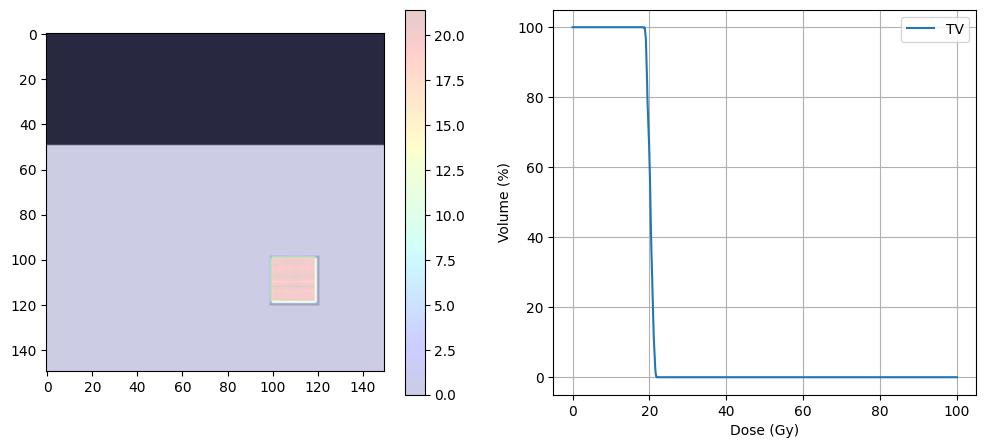

In [4]:
img_ct = ct.imageArray[:, :, Z_coord].transpose(1, 0)
contourTargetMask = roi.getBinaryContourMask()
img_mask = contourTargetMask.imageArray[:, :, Z_coord].transpose(1, 0)
img_dose = resampleImage3DOnImage3D(doseImage, ct)
img_dose = img_dose.imageArray[:, :, Z_coord].transpose(1, 0)

# Display dose
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#ax[0].axes.get_xaxis().set_visible(False)
#ax[0].axes.get_yaxis().set_visible(False)
ax[0].imshow(img_ct, cmap='gray')
ax[0].imshow(img_mask, alpha=.2, cmap='binary')  # PTV
dose = ax[0].imshow(img_dose, cmap='jet', alpha=.2)
plt.colorbar(dose, ax=ax[0])
ax[1].plot(target_DVH.histogram[0], target_DVH.histogram[1], label=target_DVH.name)
ax[1].set_xlabel("Dose (Gy)")
ax[1].set_ylabel("Volume (%)")
plt.grid(True)
plt.legend()

plt.show()